In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# 1. Start Spark session
spark = SparkSession.builder \
    .appName("ReadFromHDFS") \
    .getOrCreate()

# 2. Load cleaned CSV from HDFS
df_spark = spark.read.csv("hdfs://localhost:54310/user/hadoop/data/okcupid_clean.csv", header=True, inferSchema=True)

# 3. Select only needed columns and drop nulls
df_spark = df_spark.select("sex", "full_profile").dropna()

# 4. Convert to Pandas for word count analysis
df = df_spark.toPandas()

# 5. Filter out placeholder "."
df = df[(df["sex"] != ".") & (df["full_profile"] != ".")]

# 6. Remove punctuation & count words
df["clean_text"] = df["full_profile"].apply(lambda x: re.sub(r"[^\w\s]", "", x))
df["word_count"] = df["clean_text"].str.split().str.len()

# 7. Compute average word count by gender
avg_word_counts = df.groupby("sex")["word_count"].mean().round(2)

# 8. Show result
print("Average Word Count by Gender:")
print(avg_word_counts)

25/06/24 22:28:54 WARN Utils: Your hostname, dsbda-vm resolves to a loopback address: 127.0.1.1; using 10.0.2.15 instead (on interface enp0s3)
25/06/24 22:28:54 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/24 22:28:55 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/24 22:28:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
25/06/24 22:28:56 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.
                                                                                

Average Word Count by Gender:
sex
f    217.23
m    205.44
Name: word_count, dtype: float64


/tmp/ipykernel_5848/1458950878.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_word_counts.index, y=avg_word_counts.values, palette="viridis")


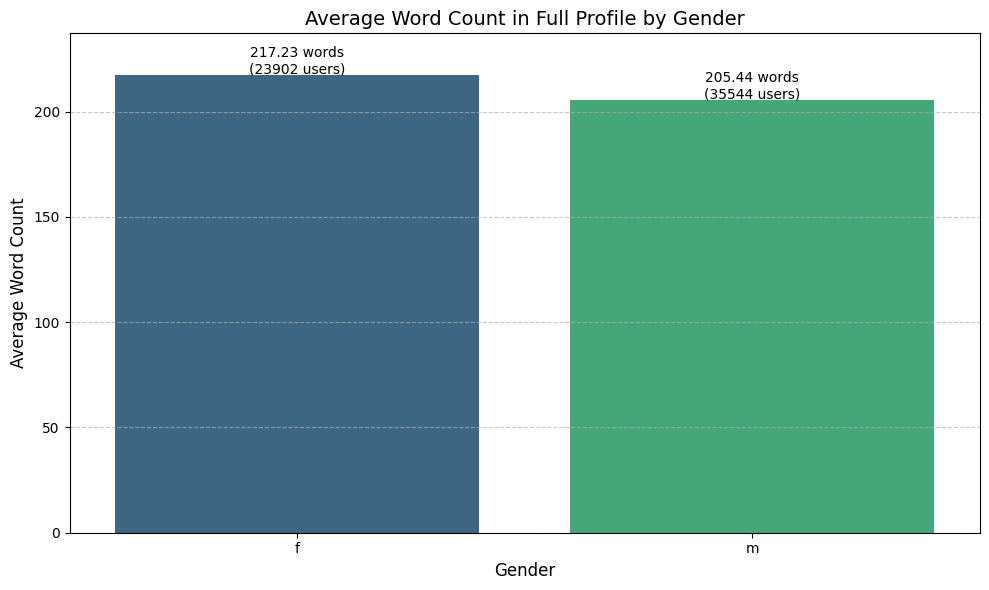

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns


gender_counts = df["sex"].value_counts()


plt.figure(figsize=(10, 6))
sns.barplot(x=avg_word_counts.index, y=avg_word_counts.values, palette="viridis")


for i, gender in enumerate(avg_word_counts.index):
    avg = avg_word_counts[gender]
    total = gender_counts.get(gender, 0)
    plt.text(i, avg + 1, f"{avg} words\n({total} users)", ha="center", fontsize=10)


plt.title("Average Word Count in Full Profile by Gender", fontsize=14)
plt.xlabel("Gender", fontsize=12)
plt.ylabel("Average Word Count", fontsize=12)
plt.ylim(0, avg_word_counts.max() + 20)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()